# Experiment 1: Music Genre Classification using Mel Spectrograms

A spectrogram is a visualization of the frequency spectrum of a signal, where the frequency spectrum of a signal is the frequency range that is contained by the signal. A mel spectrogram is a spectrogram converted to the mel scale.
Since humans do not perceive sound linearly, mel scale is used to make the inputs to the neurons more natural.The Mel Scale is a logarithmic transformation of a signal’s frequency.

Mel spectrograms have been used as inputs since a long time. [Choi et al. (2016)](https://arxiv.org/abs/1606.00298) show that mel spectrograms are superior to the other features used while audio classification like STFT and MFCCs.

I am going to experiment using Mel spectograms for music genre classification.

### Importing Necessary Libraries

In [ ]:
! pip install pydub

#Importing libraries for Audio Preprocessing 
import librosa 
import librosa.display
import skimage
import numpy as np
import pandas as pd
import imageio
import json
import IPython.display as ipd
from PIL import Image
import os
import matplotlib.pyplot as plt
#import scipy
#from scipy import misc
import glob
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil

#Importing modules needed for modeling
import tensorflow as tf
from tensorflow.python import eager #To get the number of gpus
from tensorflow.python.client import device_lib 
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, load_model

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot,plot_model
#from keras.optimizers import adam_v2
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
import random

### Checking if GPU is enabled

In [ ]:
devices = list(device_lib.list_local_devices())
gpus = [device for device in devices if "GPU" in str(device)]

print("Is cuda available?", tf.test.is_built_with_cuda())
print("Number of devices:", eager.context.num_gpus())
print("Device Name (i.e. type):", gpus)

Is cuda available? True
Number of devices: 1
Device Name (i.e. type): [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7974313647727222707
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
tf.version.VERSION

'2.8.0'

## Dataset Exploration and Initial Preprocessing
For this project, the dataset that we will be working with is GTZAN Genre Classification dataset which consists of 1,000 audio tracks, each 30 seconds long. It contains 10 genres, each represented by 100 tracks.

The 10 genres are as follows:
- Blues
- Classical
- Country
- Disco
- Hip-hop
- Jazz
- Metal
- Pop
- Reggae
- Rock

The dataset has the following folders:


- **Genres original** — A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)
- **Images original** — A visual representation for each audio file. One way to classify data is through neural networks because NN’s usually take in some sort of image representation.
- **2 CSV files** — Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file. The other file has the same structure, but the songs are split before into 3 seconds audio files.

### Note on downloading the data: 

To download the dataset, Click the Account tab in Kaggle and then scroll down to the API section and download API key.

A file named “kaggle.json” will be download which contains the username and the API key.

This is a one-time step and you don’t need to generate the credentials every time you download the dataset. However, you will have to uplaod it once to the appropriate path so that it can be used.

If you are using Google Colab, follow the following steps:
1. Install the Kaggle library
2. Make a directory named “.kaggle”
3. Copy the “kaggle.json” into this new directory
4. Allocate the required permission for this file.
5. Download the dataset
6. Unizip the dataset and remove the .zip file

### Mounting Google Drive
The alternative way to access the data is to upload the data on google drive and use it by mounting on colab. However, to make this project reproducible, I have added the above steps to download the dataset from kaggle. 

Note: My analysis has been carried out using the data present on my drive. And hence includes some 'My Drive' file paths which can be changed as needed.


In [ ]:
! pip install kaggle

In [ ]:
! rm -rf ~/.kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/  #kaggle.json is my API key. We have to upload it to colab before using this command
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification
!unzip gtzan-dataset-music-genre-classification
!rm -r gtzan-dataset-music-genre-classification.zip

### Reading and Displaying the csv files to show the type of features

In [ ]:
features_3_sec = pd.read_csv("Data/features_3_sec.csv")
print("Shape of file:",features_3_sec.shape)
features_3_sec.head()

Shape of file: (9990, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
features_30_sec = pd.read_csv("Data/features_30_sec.csv")
print("Shape of file:",features_30_sec.shape)
features_30_sec.head()

Shape of file: (1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


### Inspect an audio file from the dataset

In [ ]:
sample_audio_path = 'Data/genres_original/pop/pop.00000.wav'


# if you want to listen to the audio, uncomment below.
ipd.Audio(sample_audio_path)

### Displaying the wavelet

Audio data as time series:  [-0.0887146  -0.09524536 -0.10275269 ...  0.04016113  0.03860474
  0.02639771] 

Audio data time series shape: (661504,) 

Sampling rate (KHz): 22050 

Length of audio: 30.00018140589569


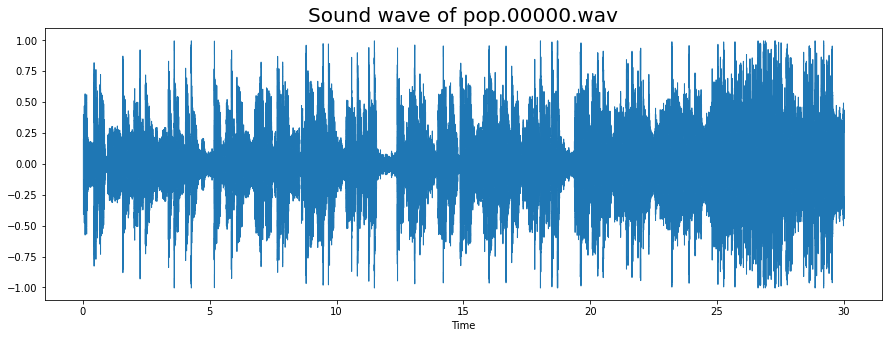

In [ ]:
#Load an audio file as a floating point time series.
audio_ts, sampling_rate = librosa.load(sample_audio_path) 

print('Audio data as time series: ', audio_ts, '\n')
print('Audio data time series shape:', np.shape(audio_ts), '\n')
print('Sampling rate (KHz):', sampling_rate, '\n')
print(f'Length of audio: {np.shape(audio_ts)[0]/sampling_rate}')

# Plot the sound wave.

plt.figure(figsize=(15, 5))
librosa.display.waveshow(y=audio_ts, sr=sampling_rate);
plt.title("Sound wave of pop.00000.wav", fontsize=20)
plt.show()

### Convert sound wave to a spectrogram

Shape of D object: (1025, 1293)


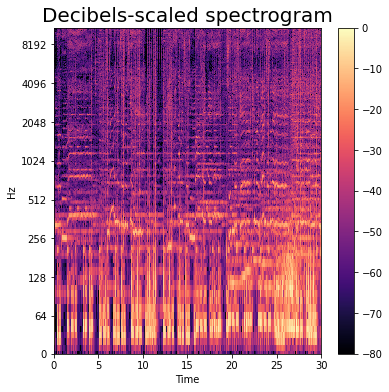

In [ ]:
# Short-time Fourier transform (STFT).

D = np.abs(librosa.stft(audio_ts, n_fft=2048, hop_length=512)) #These are default values
print('Shape of D object:', np.shape(D))

# Convert amplitude spectrogram to Decibels-scaled spectrogram.

DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the spectogram.

plt.figure(figsize = (6, 6))
librosa.display.specshow(DB, sr=sampling_rate, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Decibels-scaled spectrogram', fontsize=20)
plt.show()

### Convert sound wave to mel spectrogram.

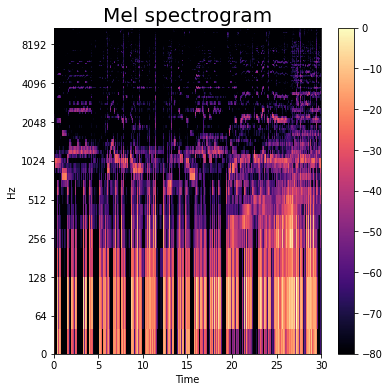

In [ ]:
y, sr = librosa.load(sample_audio_path)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(6, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Mel spectrogram", fontsize=20)
plt.show()

(288, 432, 4)


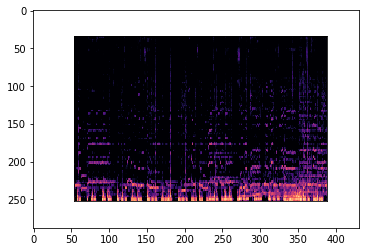

In [ ]:
# Visualize the mel spectrogram of the same sample from the dataset.

img_path = 'Data/images_original/pop/pop00000.png'
img = imageio.imread(img_path)
print(img.shape)

plt.imshow(img, interpolation='nearest')
plt.show()

We see that the GTANZ spectrogram image is actually a mel spectrogram of shape 288 x 432 with 4 channels (rgba image)

In [ ]:
S.shape #shape of mel spectrogram array

(128, 1293)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#### Remove the faulty audio file

In [ ]:
exists = os.path.isfile("/content/gdrive/MyDrive/DL_Project/Data/genres_original/jazz/jazz.00054.wav")

if exists:
  os.remove('/content/gdrive/MyDrive/DL_Project/Data/genres_original/jazz/jazz.00054.wav')
  print("Deleted the faulty file.")
else:
  print("File Deleted Already!")

File Deleted Already!


#### Get a list of class labels (genres)

In [ ]:
data_dir='/content/gdrive/My Drive/DL_Project/Data/genres_original'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

['blues',
 'metal',
 'classical',
 'hiphop',
 'country',
 'reggae',
 'jazz',
 'pop',
 'rock',
 'disco']

### Save spectrograms for each audio file

In [ ]:
for c in classes:
  path = os.path.join('/content/spectograms',f'{c}')
  os.makedirs(path)

In [ ]:
for c in classes:
  j = 0
  print("Saving spectogram for class:",c)
  for filename in os.listdir(os.path.join('/content/gdrive/My Drive/DL_Project/Data/genres_original',f"{c}")):
    song  =  os.path.join(f'/content/gdrive/My Drive/DL_Project/Data/genres_original/{c}',f'{filename}')
    j = j+1
    plt.figure(figsize=(6,6))
    y,sr = librosa.load(song,duration=29)     #Duration just under 30 secs is picked 
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'/content/spectograms/{c}/{c+str(j)}.png')
    print(filename, "saved")


#### Splitting the Spectrogram Dataset into Training, Test and Validation data

The data is present in folders and hence I am using the `splitfolders` library to create these datasets. The dataset has a total of 999 files. I have kept 80% data for model training, 1% for validation and 1% for testing.

In [ ]:
!pip install split-folders
import splitfolders

In [ ]:
os.makedirs('/content/gdrive/My Drive/DL_Project/Data/spectogram_data_29sec/')

In [ ]:
splitfolders.ratio('/content/spectograms', output="/content/gdrive/My Drive/DL_Project/Data/spectogram_data_29sec", seed=0, ratio=(0.8, 0.1,0.1)) 

Copying files: 999 files [00:10, 95.09 files/s]


### Scaling the spectrograms

`ImageDataGenerator` is used to generate batches of tensor image data with real-time data augmentation. We use it to scale the images. 

Keras’ ImageDataGenerator class provide three different functions to loads the image dataset in memory and generates batches of augmented data. These three functions are:
- flow()
- flow_from_directory()
- flow_from_dataframe()

The `flow_from_directory()` function is used since the folder contains sub-directories, each containing images of respective classes.

In [ ]:
train_dir = "/content/gdrive/My Drive/DL_Project/Data/spectogram_data_29sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=32)

validation_dir = "/content/gdrive/My Drive/DL_Project/Data/spectogram_data_29sec/val/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=32)


Found 799 images belonging to 10 classes.
Found 99 images belonging to 10 classes.


### Building the Model
Since the audio files are converted into spectrogram images, Convolutional Neural Network can be used to extract features and classify the files into different genre.

- The input spectrograms were scaled to 288 x 432 dimensions and they have 4 channels since they are rgba images. 
- Glorot uniform initializer is nothing but Xavier uniform initializer. Biases are initialized be 0 and the weights are calculated as a random number with a uniform probability distribution (U) between the range -(1/sqrt(n)) and 1/sqrt(n), where n is the number of inputs to the node.
- Batch normalization standardizes the inputs to a layer for each mini-batch. This stabilizes the learning process and reduces the number of training epochs required to train deep networks, especially CNNs.
- The activation function used for hidden layers is relu, or, rectified linear unit since it is a popular choice.
- Activation function for output layer is softmax with 10 neurons to generate probability per class

In [ ]:
def GenreModel(input_shape = (288,432,4),classes=10):
  np.random.seed(9)
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1),kernel_initializer = glorot_uniform(seed=9))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1),kernel_initializer=glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1),kernel_initializer = glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1),kernel_initializer=glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=9))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model


In [ ]:
model = GenreModel(input_shape=(288,432,4),classes=10)
opt = tf.keras.optimizers.Adam(learning_rate=0.000005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
model.summary()

Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 286, 430, 8)       296       
                                                                 
 batch_normalization (BatchN  (None, 286, 430, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 286, 430, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 213, 16)      1

In [ ]:
history = model.fit(train_generator,epochs=40,validation_data=vali_generator)

Epoch 1/40
25/25 [==============================] - 254s 10s/step - loss: 2.5002 - acc: 0.1214 - val_loss: 2.3198 - val_acc: 0.1010
Epoch 2/40
25/25 [==============================] - 6s 221ms/step - loss: 2.3072 - acc: 0.1464 - val_loss: 2.3219 - val_acc: 0.1111
Epoch 3/40
25/25 [==============================] - 6s 224ms/step - loss: 2.2789 - acc: 0.1289 - val_loss: 2.3257 - val_acc: 0.1010
Epoch 4/40
25/25 [==============================] - 6s 223ms/step - loss: 2.2589 - acc: 0.1815 - val_loss: 2.3325 - val_acc: 0.1111
Epoch 5/40
25/25 [==============================] - 6s 220ms/step - loss: 2.2441 - acc: 0.1852 - val_loss: 2.3309 - val_acc: 0.1111
Epoch 6/40
25/25 [==============================] - 6s 223ms/step - loss: 2.2297 - acc: 0.2078 - val_loss: 2.3321 - val_acc: 0.1111
Epoch 7/40
25/25 [==============================] - 6s 221ms/step - loss: 2.2106 - acc: 0.1802 - val_loss: 2.3339 - val_acc: 0.1010
Epoch 8/40
25/25 [==============================] - 7s 272ms/step - loss: 2.

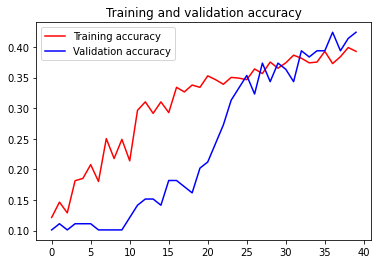

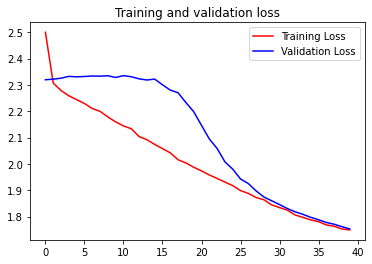

In [ ]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_performance(history)

### Save the trained model for future use

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
# save model
model.save('genreModelnoAug.h5')
print('Model Saved!')
 
import h5py 
# load model
savedModel=load_model('genreModelnoAug.h5')
savedModel.summary()

Model Saved!
Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 286, 430, 8)       296       
                                                                 
 batch_normalization (BatchN  (None, 286, 430, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 286, 430, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 21

### Predicting for test data

In [ ]:
test_dir = "/content/gdrive/My Drive/DL_Project/Data/spectogram_data_3sec/test/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=32)

Found 1798 images belonging to 10 classes.


In [ ]:
model.evaluate_generator(generator=test_generator, steps=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[2.6743738651275635, 0.13312500715255737]

### Results:

- The training loss decreases quite smoothly after each iteration where as the validation loss increases for a while and then decreases.
- The accuracy is used as a metric to evaluate the algorithm
- The training accuracy and testing accuracy of the model is around 40%
- The model performs poorly on the given task. One of the reason for this can be the less data samples available for training and validation. 
- The model performs poorly on unseen data with just around 14% accuracy

### Conclusion:

It is necessary to augment the data to achieve better performance before questioning the usefulness of mel spectrograms. 


